# Objective

- Introduce the idea of self-attention
- Implement attention layers
- Use transformer models hosted on Hugging Face for NLP tasks

# Setup

In [74]:
import math

import numpy as np
import pandas as pd
import tensorflow as tf

from transformers import BertModel, pipeline

# Limitations of RNNs


- Sequential Processing: RNNs process input data sequentially, which means they handle one element at a time. This sequential nature limits their ability to leverage parallel processing capabilities of modern GPUs, resulting in slower training times.

- Long-Term Dependencies: RNNs, including Long Short-Term Memory (LSTM) networks, struggle with long-range dependencies due to issues like vanishing and exploding gradients. As the sequence length increases, the ability to retain information from earlier inputs diminishes, making it difficult for RNNs to learn relationships between distant elements in a sequence.

# Attention & Self-Attention

To counter the limitations of RNN models like the LSTM we need a method that parallelizes the sequential computation of contextualized representations of words in a sequence. This gave rise to the idea of attention that was exploited in the 2017 paper - [Attention is all you need](https://arxiv.org/abs/1706.03762).

Let us look closely at the idea of attention by looking closely at the algorithm for attention and implementing it in code.

## Single-query attention

The algorithm for single-query attention is presented below. The objective of single-query attention is to contextualize a focal word (called the *query*) as a weighted average of the representations of the other words in the context (called the *keys*), however long the context might be. This means that instead of using a series of messages passing through the words one after another, attention directly establishes linkages between all the words in a sequence and designing an architecture to assign weights to these linkages. 

For example, consider a sequence of 5 words, where we pick one of the words as the query. We then have 4 keys. Through attention we want to estimate the weightage the query word should assign to each of the keys. In essence, we estimate 4 attention weights corresponding to each of the keys. To do so, we project the query into an attention dimension $d_{\text{attn}}$ using a matrix $\textbf{W}_q$ and each of the keys into the same attention dimension using a different matrix $\textbf{W}_k$. Intuitively, this means that we project the query and the keys into the a space of dimension $d_{\text{attn}}$ but through two different routes that will be learnt. Now that they query and keys are in the same dimension, we take pairwise dot products to get raw attention weights and scale them. Since these attention weights are dot products, we get 4 scalar values as attention weights corresponding to the 4 keys. These attention weights can be interpreted as the importance scores assigned to each of the keys.  

Now that we have the weights, we need to multiply these weights by representations of the context words. To generate these representations, we project each of the context words (now christened as values) to a output dimension using a matric $\mathbf{W}_v$. At this stage, we have 4 attention weights (scalars) and 4 output representations for each of the 4 context words. we can now do a linear combination of the output representations with the corresponding attention weights to return the contextualized representation of the query word.

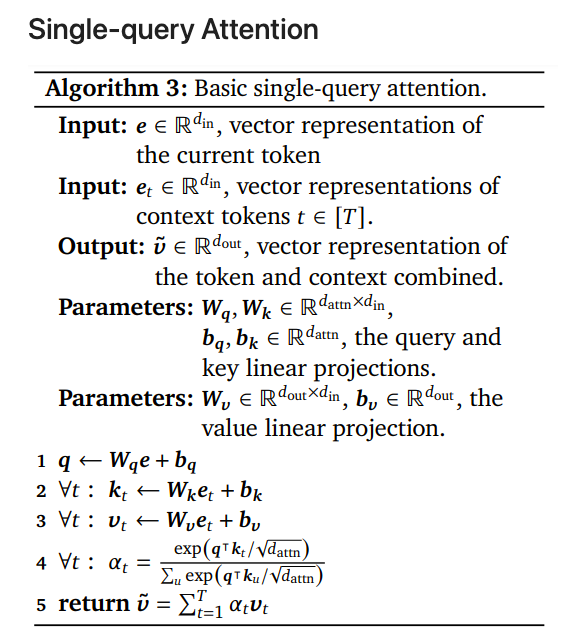

(Source: https://arxiv.org/pdf/2207.09238)

Let us now implement single-query attention in code.

In [2]:
input_sequences = [
    "This is an awesome movie",
    "Great action set pieces overall"
]

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=25,
    output_sequence_length=5
)

text_ds = tf.data.Dataset.from_tensor_slices(input_sequences)
vectorizer.adapt(text_ds)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=True
)

x_train = vectorizer(np.array([[s] for s in input_sequences])).numpy()

embedded_sequences = embedding_layer(x_train)

Vocabulary size: 12


In [3]:
x_train.shape, embedded_sequences.shape

((2, 5), TensorShape([2, 5, 100]))

In [7]:
class SingleQueryAttention(tf.Module):
    """Contextualize single input embedding by attending over context embeddings."""

    def __init__(self, d_x: int, d_z: int, d_attn: int, d_out: int, do_init: bool = True):
        super().__init__()  # Properly initialize the tf.Module without arguments
        self.d_x = d_x
        self.d_z = d_z
        self.d_attn = d_attn
        self.d_out = d_out
        self.do_init = do_init

        self.scale = 1 / math.sqrt(d_attn)

        # Define the weight tensors
        self.w_q = tf.Variable(tf.random.uniform([d_x, d_attn]), trainable=True)
        self.w_k = tf.Variable(tf.random.uniform([d_z, d_attn]), trainable=True)
        self.w_v = tf.Variable(tf.random.uniform([d_z, d_out]), trainable=True)

        # Define the bias tensors
        self.b_q = tf.Variable(tf.zeros([d_attn]), trainable=True)
        self.b_k = tf.Variable(tf.zeros([d_attn]), trainable=True)
        self.b_v = tf.Variable(tf.zeros([d_out]), trainable=True)

        if self.do_init:
            self.init_weights()

    def init_weights(self):
        initializer = tf.keras.initializers.GlorotNormal(seed=42)
        self.w_q.assign(initializer([self.d_x, self.d_attn]))
        self.w_k.assign(initializer([self.d_z, self.d_attn]))
        self.w_v.assign(initializer([self.d_z, self.d_out]))

        self.b_q.assign(tf.zeros([self.d_attn]))
        self.b_k.assign(tf.zeros([self.d_attn]))
        self.b_v.assign(tf.zeros([self.d_out]))

    def __call__(self, x1: tf.Tensor, z: tf.Tensor, mask: tf.Tensor):
        # Ensure x1 is 2D [1, d_x] before multiplication
        q = tf.matmul(tf.expand_dims(x1, axis=0), self.w_q) + self.b_q
        k = tf.matmul(z, self.w_k) + self.b_k
        v = tf.matmul(z, self.w_v) + self.b_v

        # Now q is [1, d_attn] and k is [l_z, d_attn]
        score = tf.matmul(q, k, transpose_b=True) * self.scale
        score = tf.where(tf.cast(mask, tf.bool), score, tf.fill(score.shape, -float("Inf")))
        attention = tf.nn.softmax(score, axis=-1)

        # Now, attention is [1, l_z] and v is [l_z, d_out]
        vtilde = tf.matmul(attention, v)

        return {
            "q": q,
            "k": k,
            "v": v,
            "score": score,
            "attention": attention,
            "vtilde": tf.squeeze(vtilde),  # Removing the added dimension
        }

Consider a sequence where the query and the keys are embedded in 100 dimensions. We want to compute the single query attention of using an attention space of 200 dimensions and an output space of 400 dimensions.

In [8]:
d_x, d_z, d_attn, d_out = 100, 100, 200, 400
mask = tf.constant([1, 1, 1, 1], dtype=tf.int32)

In [9]:
sqa = SingleQueryAttention(d_x, d_z, d_attn, d_out)

Let us now take the first word in the first sequence 'this' as the query. The rest of the words in the sentence ('is', 'an', 'awesome', 'movie') are the other 4 keys. Each of them is embedded in a 100 dimensional space.

In [10]:
embedded_sequences[0][0].shape # single query from the first sequence - 'this'

TensorShape([100])

In [11]:
embedded_sequences[0][1:].shape # rest of the tokens are the context

TensorShape([4, 100])

Now let us contextualize the word 'this' using the other 4 words in the sentence. Note that we are computing self-attention here where the query focuses only on the other tokens in the context.

In [12]:
contextualized_token_this = sqa(
    embedded_sequences[0][0],
    embedded_sequences[0][1:],
    mask
)

Notice how the first argument to this instantiation is the embedding (100-dimensions) of the first word ('this') while the second input (of shape (4, 100)) contains embeddings of the 4 words that follow this word. The output of this operation is the weighted average of the representations of these four context words projected into a 400 dimensional space.

Let us first look at the attention scores.

In [14]:
contextualized_token_this['attention']

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.25026205, 0.24983627, 0.24989691, 0.25000468]], dtype=float32)>

The shapes of the Q, K, V matrices are:

In [17]:
contextualized_token_this['q'].shape, contextualized_token_this['k'].shape, contextualized_token_this['v'].shape

(TensorShape([1, 200]), TensorShape([4, 200]), TensorShape([4, 400]))

In [20]:
contextualized_token_this['vtilde'].shape

TensorShape([400])

The final output of course is the contextualized representation of the word 'this' as an attention weighted average of all the context words.

## Attention Heads (Self-Attention)

So far, we have dealt with single-query attention. However, we need to parallelize this computation so that in one shot we compute the attention scores of all the words the sequences where each word takes turns to be the query and the rest of the words take turns to be the keys and values.

To parallelize attention computation, a batch of 2 sequences is converted into multiple sequences like so using broadcasting:

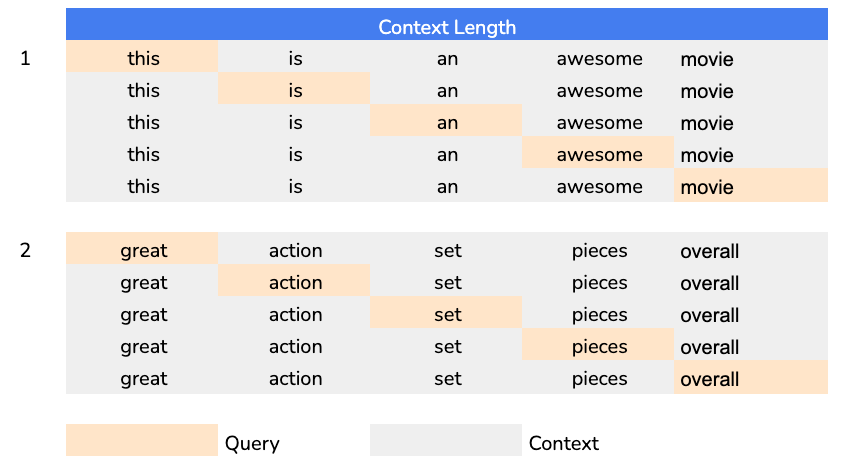

In the above figure:

*Input*
- batch size ($b$) = 2
- number of tokens in each sample (context length, $l_z$) = 5
- query dimension ($d_{\text{in}}) = 100$
- context tokens (keys) for each query = $l_z = 5$
- each context token (key) dimension = $d_{\text{in}} = 100$

We want to compose an attention head that:
- pushes the query and key tokens to a dimension: $d_{\text{attn}}=200$
- transformed the query tokens into an output dimension: $d_{\text{out}}=400$

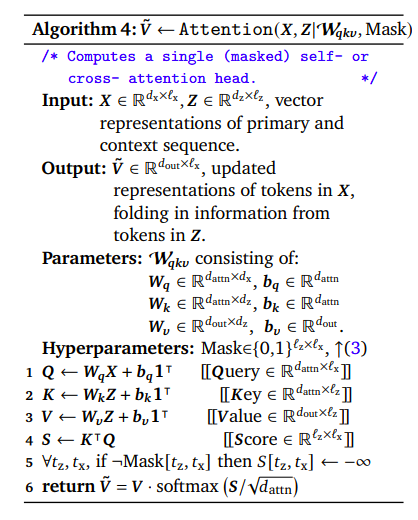

(Source: https://arxiv.org/pdf/2207.09238)

In the above algorithm computing the attention scores is achieved at once with the matrix operation $\textbf{Q} \textbf{K}^T$ (see figure below for the intuition).

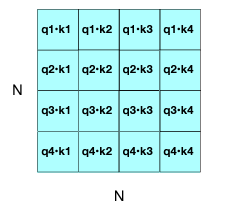

(Source: https://web.stanford.edu/~jurafsky/slp3/9.pdf)

An important point to note here is that we are also computing the attention weight of a query words with itself (i.e., $q1 \cdot k1, q2 \cdot k2, \ldots$). The idea here is that the query word enters with its own global meaning throuh its embedding and learns to retain the required portion of its attention weight along with contextualizing itself within the context through the other attention scores.

Let us now look at an attention head (i.e., a layer that implements parallelized attention presented in the above algorithm).

**Single-head attention**

In [39]:
attention_layer = tf.keras.layers.MultiHeadAttention(
    num_heads=1,
    key_dim=200,
    value_dim=400,
    output_shape=600
)

In [40]:
contextualized_sequences = attention_layer(embedded_sequences, embedded_sequences)

Notice how we are passing in the embedded sequences two times as the input to this layer. This means we want to compute self-attention where the words in the sentence look at all the other words in the sequence to get contextualized.

In [41]:
embedded_sequences.shape, contextualized_sequences.shape

(TensorShape([2, 5, 100]), TensorShape([2, 5, 600]))

The above output indicates that we pass in a batch of 2 sequences of 5 words each embedded in a 100 dimensional space to the attention layer. The attention layer contextualizes this using Q, K, V matrices and returns a 600 dimensional vector for each of the 5 words in the sequence. Hence the output is of dimension `(2, 5, 600)`. 

Tracing the shapes: 

$\textbf{Q} : (2, 5, 200)$ due to multiplication by the matrix $\textbf{W}_q: (200, 100)$

$\textbf{K} : (2, 5, 200)$ due to multiplication by the matrix $\textbf{W}_k: (200, 100)$

$\textbf{V} : (2, 5, 400)$ due to multiplication by the matrix $\textbf{W}_v: (400, 100)$

$\textbf{S} = \textbf{Q} \textbf{K}^T : (2, 5, 200) \times (2, 200, 5) = (2, 5, 5)$. All 25 attention weights are obtained at once.

$\textbf{V} \cdot \text{softmax}({\textbf{S}}) : (2, 5, 400) \cdot (2, 5, 5) = (2, 5, 400)$.

Final projection of $\textbf{V}$ to the output dimension of 600: $(2, 5, 400) \cdot (2, 400, 600) = (2, 5, 600)$

In [42]:
embedded_sequences[0][0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([ 0.01913438,  0.00914758,  0.03304175, -0.03487156,  0.04355717,
        0.01662772,  0.03997034,  0.00222472,  0.0210023 , -0.0010021 ,
        0.03644056,  0.00728772, -0.02338135, -0.0202518 , -0.03972382,
        0.04254675, -0.00144975,  0.02628667, -0.00412148,  0.03847638,
       -0.00179255, -0.00688612,  0.00444616, -0.04924251, -0.022129  ,
       -0.00354292, -0.01741561,  0.00194638, -0.01106539,  0.00911565,
       -0.04811901,  0.03475614, -0.036596  , -0.01953546, -0.02824791,
       -0.00390464,  0.00823386, -0.00172872,  0.02713735,  0.01535858,
       -0.03268542,  0.0211505 ,  0.00986153, -0.00413234,  0.02808838,
       -0.04035937,  0.00782803,  0.04733897, -0.02459194,  0.03184915,
        0.00472695, -0.03124273,  0.0208453 ,  0.02958074, -0.04256972,
        0.03625058,  0.03054852, -0.01344233, -0.04293111,  0.0134641 ,
       -0.01510706, -0.00782233,  0.04238716,  0.04257346, -0.03346509,
       -0.042424

In [43]:
contextualized_sequences[0][0]

<tf.Tensor: shape=(600,), dtype=float32, numpy=
array([-1.20323682e-04,  9.58369870e-04,  4.68973885e-04, -1.75950793e-03,
        1.06312730e-03, -4.22997575e-04,  1.30446302e-03, -4.28446656e-04,
        7.13172252e-04,  3.79836827e-04,  3.85726336e-04,  1.29942156e-04,
       -2.02764160e-04,  1.43856124e-03, -4.12374618e-04, -7.62589916e-04,
       -6.88414497e-04,  7.36227492e-04, -8.87957867e-06,  2.95249803e-04,
       -6.21405430e-04,  8.59506836e-04,  7.85416691e-04, -3.44994769e-04,
        6.70223089e-04, -4.91960032e-04, -2.13292384e-04,  6.43961946e-04,
       -4.70308063e-04, -5.73841971e-05, -1.16137392e-03, -2.84841808e-04,
       -8.12783139e-04,  2.95229867e-04,  8.90025753e-04,  4.77168447e-04,
        9.97892115e-04, -1.60032988e-03,  2.69945303e-04,  3.61468992e-05,
        1.07658503e-03,  2.59319146e-04,  7.63533462e-04,  1.04304450e-03,
        4.76504851e-04, -9.28763533e-04,  4.48511943e-04, -1.18609914e-03,
        7.13356072e-04,  8.34335951e-05,  3.57649697

Counting the parameters:

$\textbf{W}_q: 200 \times 100 = 20,000$

$\textbf{W}_k: 200 \times 100 = 20,000$

$\textbf{W}_v: 400 \times 100 = 40,000$

Total parameters to generate $\textbf{Q}$, $\textbf{K}$ and $\textbf{V}$ matrices = $80,000$. Adding the respective bias terms ($200 + 200 + 400 = 800$), we get a total of $80,800$.

Now we project the 400 dimensional output from the attention computation to a output dimension of 600. So, this needs multiplication of a matric of dimension (400, 600) and adds $400 \times 600 = 240,000$ parameters. Adding in the bias: $240,000 + 600 = 240,600$.

In total, we have $240,600 + 80,800 = 321,400$ parameters in the attention layer.

In [44]:
attention_layer.count_params()

321400

**Multi-head attention**

Instead of composing a layer with a single attention head, we can have a layer with multiple attention heads. This allows for different perspectives to be learnt from the same batch of sequences. 

However, now that we will have multiple volumes of the same dimensions from each attention head, these outputs from multiple attention heads are concatenated and projected to the output dimension.

In [45]:
attention_layer = tf.keras.layers.MultiHeadAttention(
    num_heads=2,
    key_dim=200,
    value_dim=400,
    output_shape=600
)

In [46]:
contextualized_sequences = attention_layer(embedded_sequences, embedded_sequences)

In [47]:
embedded_sequences.shape, contextualized_sequences.shape

(TensorShape([2, 5, 100]), TensorShape([2, 5, 600]))

The output is still (2, 5, 600) but the parameter count is going to increase due to the extra parameters from the projection matrix.

In [48]:
attention_layer.count_params()

642200

Tracing the parameter count: 

Each attention head produces an output volume of (2, 5, 400) with a total $\textbf{Q}$, $\textbf{K}$, $\textbf{V}$ parameter count of $80,800$. However, we have two such attention heads, each head with its own $\textbf{Q}$, $\textbf{K}$, $\textbf{V}$'s, hence the total parameter count for both heads for attention computation is: $80,800 \times 2 = 161,600$.

Now the output volume from the attention computation after concatenation of the two heads is: $(2, 5, 800)$. This needs to be projected to a output volume of $(2, 5, 600)$. This requires a matrix of dimension: $(800, 600)$ adding a total of $800 \times 600 = 480,000$ parameters + $600$ bias = $480,600$ parameters.

The total parameters in the attention layer are thus: $480,600 + 161,600 = 642,200$ 


In [19]:
embedded_sequences[0][0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([ 0.02245844,  0.03765925,  0.04700512, -0.02768513,  0.04134882,
        0.00218997,  0.02530967,  0.00200175, -0.03571771,  0.00556364,
       -0.01170802,  0.0044724 ,  0.045225  ,  0.00833821, -0.04478101,
       -0.01631057, -0.035563  ,  0.00243866, -0.00976983,  0.01527433,
        0.03551159,  0.02068892, -0.02613124, -0.03259542, -0.01025737,
        0.00156022, -0.02261151,  0.02824502,  0.02804575,  0.00214014,
       -0.04695041,  0.01938647,  0.01780857,  0.01664938, -0.00525398,
        0.04038263, -0.01502271,  0.02812492,  0.04586783,  0.04877982,
       -0.03987523,  0.0152433 ,  0.03166474,  0.04470271,  0.01234252,
       -0.00867931,  0.03603483, -0.01527689,  0.04632917,  0.01497499,
       -0.01117093,  0.0449108 ,  0.00316869,  0.02892954,  0.02548492,
        0.01509291, -0.03689294, -0.03526074, -0.01589279,  0.04149463,
        0.02634675,  0.03870269, -0.01459169, -0.02975826,  0.03295747,
        0.030431

In [20]:
contextualized_sequences[0][0]

<tf.Tensor: shape=(400,), dtype=float32, numpy=
array([-3.15370446e-04, -1.21761439e-03,  5.50305005e-04, -9.72661714e-04,
        3.28465743e-04,  1.03302300e-05,  5.11285150e-04, -2.14627362e-04,
       -3.22175765e-04,  1.66970189e-04, -1.39218639e-04, -9.19084065e-04,
        7.11414614e-04, -4.48505831e-04,  2.88495212e-05,  1.16546312e-03,
        1.79333426e-03,  2.63849273e-04, -2.79014406e-04, -6.89430279e-04,
       -4.18186450e-04,  9.66214924e-04, -2.05676164e-03, -1.31552853e-03,
       -1.02487189e-04, -1.51995907e-03, -5.37785178e-04, -4.56170092e-05,
       -1.28557032e-03, -1.58261275e-04, -9.27885121e-04, -6.65506697e-04,
        1.22287718e-04,  1.32018962e-04,  5.88271068e-04,  1.43055641e-03,
        6.45530585e-04, -1.16701995e-03,  6.95028459e-04,  8.06597236e-04,
       -1.81159921e-04, -1.10213936e-03, -2.21937371e-04,  5.27690863e-05,
        1.00374245e-03, -2.58738321e-04,  2.99403025e-03, -5.46199968e-04,
       -5.91055898e-04,  1.12655677e-03,  1.20776286

# Position Embedding

While attention heads parallelize the computation of attention scores, they have no sense of the position of a token; this has to be explicitly patched in. Let us see how.

In [53]:
input_sequences = [
    "This is an awesome movie",
    "Great action set pieces overall"
]

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=25,
    output_sequence_length=5
)

text_ds = tf.data.Dataset.from_tensor_slices(input_sequences)
vectorizer.adapt(text_ds)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

x_train = vectorizer(np.array([[s] for s in input_sequences])).numpy()

Vocabulary size: 12


In [54]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In the above code, we are adding a new position embedding for each word in the sequence. This is a unique vector that is of same length as the embedding dimension but is shared across all the words in the samples at the same position. For example, all the second words of the sequence should have the same position embedding. This is achieved by initilizing the positions from 0 to maximum sequence length during the forward pass and index these positions in the from the position embedding matrix. 

Note that our token and position embedding layer is directly adding these two discrete sources of information: word meaning and word position into one comprehensive embedding value.

In [58]:
embedding_layer = TokenAndPositionEmbedding(5, 12, 100)

In [59]:
embedded_sequences = embedding_layer(x_train)

In [60]:
embedded_sequences.shape

TensorShape([2, 5, 100])

# A Simple Transformer Model

Now we have all the building blocks to create a simple transformer model with one layer.

In [62]:
tf.keras.backend.clear_session()

# Define inputs
inputs = tf.keras.layers.Input(shape=(5,))

# Initialize and apply the TokenAndPositionEmbedding layer
embedding_layer = TokenAndPositionEmbedding(5, 12, 100)
embedded_inputs = embedding_layer(inputs)

# Apply the MultiHeadAttention layer
# Since we omit the output shape, the output from the transformer layer will be projected back to the 
# dimension of the input layer.
transformer_layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=100)
contextualized_inputs = transformer_layer(embedded_inputs, embedded_inputs)

# Apply GlobalAveragePooling1D and Dense layers
x = tf.keras.layers.GlobalAveragePooling1D()(contextualized_inputs)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 token_and_position_embeddi  (None, 5, 100)               1700      ['input_1[0][0]']             
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 multi_head_attention (Mult  (None, 5, 100)               80700     ['token_and_position_embedding
 iHeadAttention)                                                    [0][0]',                  

# The Original Transformer

While we have built up a transformer layer that implements paralleized self-attention, this was not the way it was discovered. The original transformer model from the attention is all you need paper is presented below. 

This architecture was invented for language translation and hence has two parts. The left side (called the *encoder*) is identical to the transformer layer we have built in the previous section (including token and position embedding) with the addition of a feedforward layer at the top. Also while we have used one transformer layer, this architecture has several encoder blocks, each block feeding its output volume to the next block as input. In effect, the encoder block is responsible to create a rich feature representation of each word in the batch of sequences.

The right side (called the *decoder*) is supposed to take in the feedback of the context from the encoder and generate the translation - word by word. This is why there is a linear layer at the end of the decoder side that outputs probabilities post softmax to the vocabulary space. We will inspect the decoder side of this architecture more closely when we look at LLM architectures in the next session.

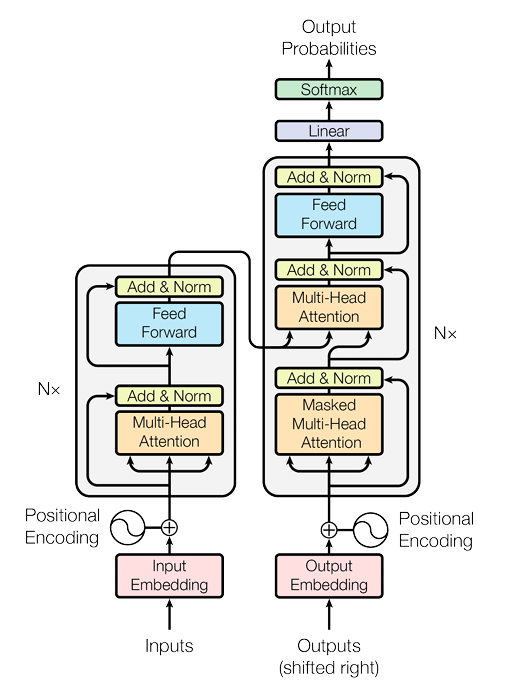

(Source: https://arxiv.org/pdf/1706.03762)

# Encoder-only Models

Let us now implement the encoder portion of the original transformer (above figure) as one encoder block.

In [63]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [65]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output) # skip connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output) # skip connection

There are two parameters for the attention layer in this encoder block: number of heads and the key dimension. Since there is no output dimension mentioned, the output shape will be scaled back to the shape of the input as discussed in the previous section.

The feedforward layer is a composition of two dense layers: the first dense layer projects each word coming out of the attention layer to a different dimension (`ff_dim`) and the second dense layer brings it back to the embedding dimension.

The skip connections in the encoder block are implemented as additive outputs: `out1` and the final output.

Layer normalization ensures that the weights are restricted to have $\mu = 0, \sigma = 1$ and stabilize training.

This encoder block is a complete implementation of the left portion of the original transformer paper. Let us now pass a small sample through this encoder block and observe the output shape.

In [66]:
input_sequences = [
    "This is an awesome movie",
    "Great action set pieces overall"
]

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=25,
    output_sequence_length=5
)

text_ds = tf.data.Dataset.from_tensor_slices(input_sequences)
vectorizer.adapt(text_ds)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

x_train = vectorizer(np.array([[s] for s in input_sequences])).numpy()

Vocabulary size: 12


In [67]:
embedding_layer = TokenAndPositionEmbedding(5, 12, 100)

In [68]:
embedded_sequences = embedding_layer(x_train)

In [69]:
embedded_sequences.shape

TensorShape([2, 5, 100])

In [70]:
encoder_block = EncoderBlock(embed_dim=100, num_heads=2, ff_dim=256)

In [71]:
contextualized_sequences = encoder_block(embedded_sequences)

In [72]:
contextualized_sequences.shape

TensorShape([2, 5, 100])

As we can see from the above outputs, the embedded sequences of shape $(2, 5, 100)$ enter the encoder block comprising 2 heads and an attention dimension of 100. The contextualize batch of sequences from the attention layer is hence: $(2 5, 100)$. Since we do not mention any output dimension, this volume is scaled to be of the same dimension as the input, that is $(2, 5, 100)$. Then this volume goes into the feed forward layer where the volume becomes $(2, 5, 256)$ after the first dense layer and back to $(2, 5, 100)$ after the second dense layer. This is hence the shape of the output from the encoder block. 

# Training Encoder-only Models

With this block we can can train encoder-only models for sentiment classification as we have done for the other algorithms so far (RNN, LSTM) like so:

In [75]:
tf.keras.backend.clear_session()

dataset_path = 'labeled_sentiments_data.tsv'
dataset = pd.read_csv(dataset_path, sep='\t')
sample_dataset = dataset.sample(1000)

reviews = sample_dataset.review
targets = sample_dataset.sentiment

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=200
)

text_ds = tf.data.Dataset.from_tensor_slices(reviews).batch(128)

vectorizer.adapt(text_ds)

x_train = vectorizer(np.array([[s] for s in reviews])).numpy()
y_train = np.array(targets)

In [76]:
maxlen = 200
vocab_size = len(vectorizer.get_vocabulary())
embed_dim = 128
num_heads = 2
ff_dim = 256

In [77]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = EncoderBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [78]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 128)          2585600   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 encoder_block (EncoderBloc  (None, 200, 128)          198400    
 k)                                                              
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [79]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [80]:
model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
7/7 [==============================] - 9s 871ms/step - loss: 0.6993 - accuracy: 0.5125 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 2/10
7/7 [==============================] - 5s 749ms/step - loss: 0.6966 - accuracy: 0.5213 - val_loss: 0.6921 - val_accuracy: 0.4900
Epoch 3/10
7/7 [==============================] - 7s 950ms/step - loss: 0.6868 - accuracy: 0.5412 - val_loss: 0.6887 - val_accuracy: 0.4950
Epoch 4/10
7/7 [==============================] - 6s 864ms/step - loss: 0.6728 - accuracy: 0.6112 - val_loss: 0.6807 - val_accuracy: 0.4950
Epoch 5/10
7/7 [==============================] - 6s 871ms/step - loss: 0.6322 - accuracy: 0.6825 - val_loss: 0.6499 - val_accuracy: 0.6250
Epoch 6/10
7/7 [==============================] - 6s 804ms/step - loss: 0.5074 - accuracy: 0.7788 - val_loss: 0.7155 - val_accuracy: 0.6050
Epoch 7/10
7/7 [==============================] - 6s 782ms/step - loss: 0.2309 - accuracy: 0.9150 - val_loss: 0.6359 - val_accuracy: 0.7150
Epoch 8/10
7/7 [====

Notice how we have surpassed the accuracy from LSTM models on this dataset using just one encoder block. Encoder-only models such as the one we have built and trained in this section that generate rich feature representations of the input sequences are often referred to as the BERT-family of models. BERT here stands for Bidirectional Encoder Representations from Transformers referring to the family of models that use only the encoder-portion of the original transformer to generate rich features. 

# Accessing the BERT-family

Several variants of BERT are available on HuggingFace that can be used out of the box for various NLP tasks. Let us look at two such popular models.

## Sentiment Classification

In [81]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

In [117]:
sentiment_classifier = pipeline(
    'sentiment-analysis',
    model=model_name,
    tokenizer=model_name
)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaFo

(Source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [83]:
sentiment_classifier.model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Notice how the architecture of the above model is an extension of the single encoder model we built in the previous section. There are 12 encoder blocks in this architecture and the model was trained on a vocabulary of 50,265 words to predict the sentiment to belong to 3 classes - positive, negative and neutral. 

In [84]:
input_sequences = [
    "This is an awesome movie",
    "Great action set pieces overall"
]

In [85]:
sentiment_classifier(input_sequences)

[{'label': 'positive', 'score': 0.9824944138526917},
 {'label': 'positive', 'score': 0.960384726524353}]

In [130]:
input_sequences = sample_dataset.review.sample(3).to_list()

In [131]:
input_sequences

["There is a lot of talk of torture these days. That's all this movie is. It's about a good person who makes a bad decision. Because of his kindness, he becomes vulnerable to two psychotic women. From then on its a just-for-kicks assault on him. I don't know at what point you do something about it. There is a wife and child out there somewhere; he has great feelings of guilt and fear. But there should have been some times when he could have acted. The movie seems to be somebody's joke. I suppose in the wake of the Manson murders, we had a bit of a fixation on the likes of these two. Nevertheless, why would someone make a film like this? What appeals does it have except for sadism. The conclusion is totally unsatisfying, but that could have been remedied with an obvious plot twist. Oh, well. Another hour and a half of my life.",
 'Wasn\'t quite sure what to expect with this one, outside of the uniform positive reviews I\'ve read. Turns out, I could have never imagined this movie, becaus

The maximum sequence length for the BERT model we downloaded is 514, so we need to trim reviews with more than 514 tokens.

In [136]:
sentiment_classifier(input_sequences, truncation=True, max_length=514)

[{'label': 'negative', 'score': 0.8731400966644287},
 {'label': 'neutral', 'score': 0.4506315290927887},
 {'label': 'neutral', 'score': 0.5503965616226196}]

# Emotion Classification

In [143]:
model_name = "michellejieli/emotion_text_classifier"

In [144]:
classifier = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [145]:
classifier.model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [146]:
input_sequences = sample_dataset.review.sample(3).to_list()

In [149]:
classifier(input_sequences, truncation=True, max_length=514)

[{'label': 'neutral', 'score': 0.9211248159408569},
 {'label': 'neutral', 'score': 0.814215898513794},
 {'label': 'joy', 'score': 0.8188254237174988}]